# Model Selection

## package

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, ElasticNetCV, LassoCV, RidgeCV, \
    LinearRegression, Ridge, ARDRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from google.colab import drive

## data loading

In [ ]:
path = "/content/drive/My Drive/COMP4433"

train = pd.read_csv(path+'/train_fs1.csv')
test = pd.read_csv(path+'/test_fs1.csv')
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

index_train = train.index
all_data = pd.concat((train, test)).reset_index(drop=True)

def RLMSE(actual, predicted):
  return mean_squared_error(np.log(actual), np.log(predicted), squared=False)
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

all_data = pd.get_dummies(all_data)
train = all_data[:train.shape[0]]
test = all_data[test.shape[0]:]
test.drop(["SalePrice"], axis=1, inplace=True)

define the RLMSE function to evaluate the performance of the models

Through testing, the train_fs1 performs better than train_fs2.


In [ ]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,2.352941,7.5,2.076677,0.334198,10.0,5.0,10.0,10.0,0.0,10.0,0.0,2.083333,2.50,2.857143,0.0,7.142857,6.666667,5.00,9.492754,8.833333,2.0,0.0,8.571429,8.666667,3.333333,1.22500,6.666667,10.0,4.0,5.0,10.0,10.0,3.333333,3.226691,10.000000,0.642123,2.675000,2.0,0.0,10.0,10.0,4.697470,4.178561,3.333333,6.666667,5.0,3.75,3.333333,6.666667,10.000000,0.000000,6.0,1.666667,6.666667,3.942446,10.0,10.0,10.0,0.000000,1.115174,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,2.505338
1,0.000000,7.5,2.555911,0.387950,10.0,5.0,10.0,10.0,0.0,5.0,0.0,10.000000,1.25,2.857143,0.0,2.857143,5.555556,8.75,7.536232,4.333333,2.0,0.0,5.714286,5.333333,6.666667,0.00000,10.000000,10.0,2.0,5.0,10.0,2.5,0.000000,4.469835,10.000000,1.215753,3.943750,2.0,0.0,10.0,10.0,0.000000,2.818099,0.000000,6.666667,0.0,3.75,3.333333,10.000000,10.000000,3.333333,10.0,1.666667,6.666667,3.309353,10.0,10.0,10.0,3.477246,0.000000,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,2.493950
2,2.352941,7.5,2.172524,0.465073,10.0,5.0,0.0,10.0,0.0,10.0,0.0,2.083333,2.50,2.857143,0.0,7.142857,6.666667,5.00,9.347826,8.666667,2.0,0.0,8.571429,8.666667,3.333333,1.01250,6.666667,10.0,4.0,5.0,10.0,5.0,3.333333,2.221207,10.000000,1.857877,2.875000,2.0,0.0,10.0,10.0,4.763476,4.409353,3.333333,6.666667,5.0,3.75,3.333333,6.666667,10.000000,3.333333,10.0,1.666667,6.666667,4.374101,10.0,10.0,10.0,0.000000,0.767824,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,2.510994
3,2.941176,7.5,1.916933,0.385613,10.0,5.0,0.0,10.0,0.0,0.0,0.0,2.500000,2.50,2.857143,0.0,7.142857,6.666667,5.00,3.115942,3.333333,2.0,0.0,9.285714,10.000000,6.666667,0.00000,10.000000,10.0,0.0,10.0,2.5,10.0,0.000000,0.987203,10.000000,2.311644,2.362500,2.0,5.0,10.0,10.0,4.158416,4.199818,3.333333,3.333333,0.0,3.75,3.333333,6.666667,10.000000,3.333333,4.0,8.333333,10.000000,4.618705,10.0,10.0,10.0,0.000000,0.639854,4.927536,0.0,0.0,10.0,10.0,2.5,10.0,0.0,2.472278
4,2.352941,7.5,2.683706,0.605763,10.0,5.0,0.0,10.0,0.0,5.0,0.0,6.250000,2.50,2.857143,0.0,7.142857,7.777778,5.00,9.275362,8.333333,2.0,0.0,8.571429,8.666667,3.333333,2.18750,6.666667,10.0,4.0,5.0,10.0,0.0,3.333333,2.993601,10.000000,2.097603,3.578125,2.0,0.0,10.0,10.0,5.792079,5.660492,3.333333,6.666667,5.0,5.00,3.333333,6.666667,10.000000,3.333333,10.0,1.666667,6.666667,6.014388,10.0,10.0,10.0,2.240373,1.535649,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,2.520050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,2.352941,7.5,1.980831,0.309285,10.0,5.0,10.0,10.0,0.0,10.0,0.0,3.333333,2.50,2.857143,0.0,7.142857,5.555556,5.00,9.202899,8.333333,2.0,0.0,8.571429,8.666667,6.666667,0.00000,10.000000,10.0,4.0,5.0,10.0,10.0,10.000000,0.000000,10.000000,4.079623,2.978125,2.0,0.0,10.0,10.0,3.817382,3.987246,0.000000,6.666667,5.0,3.75,3.333333,10.000000,10.000000,3.333333,10.0,1.666667,6.666667,3.309353,10.0,10.0,10.0,0.000000,0.731261,0.000000,0.0,0.0,10.0,10.0,2.5,10.0,8.0,2.490934
1450,0.000000,7.5,2.715655,0.555049,10.0,5.0,10.0,10.0,0.0,10.0,0.0,5.833333,2.50,2.857143,0.0,2.857143,5.555556,6.25,7.681159,6.333333,2.0,0.0,6.428571,6.666667,10.000000,

In [ ]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1459,2.352941,7.5,2.396166,0.406647,10.0,5.0,0.0,10.0,0.0,0.0,0.0,3.333333,2.5,2.857143,0.0,7.142857,5.555556,5.0,8.768116,7.333333,2.0,0.0,4.285714,4.000000,6.666667,0.0000,10.0,10.0,4.0,5.0,10.0,10.0,10.000000,0.000000,10.000000,3.266267,2.384375,2.0,5.0,10.0,10.0,4.906491,4.011540,0.000000,6.666667,5.0,3.75,3.333333,10.000000,10.0,3.333333,10.0,1.666667,0.000000,3.165468,10.0,10.0,10.0,1.831972,1.535649,0.0,0.0,0.0,10.0,10.0,2.5,10.0,8.0
1460,0.000000,7.5,0.000000,0.312230,10.0,5.0,0.0,10.0,0.0,10.0,0.0,3.333333,2.5,2.857143,0.0,2.857143,5.555556,7.5,8.695652,9.500000,2.0,0.0,4.285714,4.000000,6.666667,0.0000,10.0,5.0,4.0,5.0,10.0,10.0,0.000000,4.273309,10.000000,0.997432,3.650000,2.0,0.0,10.0,10.0,0.000000,2.590343,3.333333,6.666667,0.0,3.75,3.333333,10.000000,10.0,0.000000,6.0,1.666667,0.000000,3.021583,10.0,10.0,10.0,5.635939,0.383912,0.0,0.0,0.0,10.0,0.0,7.5,10.0,8.0
1461,2.352941,7.5,2.012780,0.331954,10.0,5.0,0.0,10.0,0.0,10.0,0.0,3.333333,2.5,2.857143,0.0,7.142857,5.555556,5.0,9.130435,8.000000,2.0,0.0,8.571429,8.666667,6.666667,0.0000,10.0,10.0,4.0,5.0,10.0,10.0,10.000000,0.000000,10.000000,3.377568,2.465625,2.0,5.0,10.0,10.0,3.718372,3.434558,0.000000,6.666667,5.0,3.75,3.333333,10.000000,10.0,3.333333,4.0,1.666667,0.000000,2.827338,10.0,10.0,10.0,0.000000,1.371115,0.0,0.0,0.0,10.0,10.0,2.5,10.0,8.0
1462,0.000000,7.5,2.715655,0.414873,10.0,5.0,10.0,10.0,0.0,10.0,0.0,3.333333,2.5,2.857143,0.0,2.857143,6.666667,5.0,8.550725,6.666667,2.0,0.0,4.285714,4.000000,6.666667,0.0000,10.0,10.0,4.0,5.0,10.0,2.5,3.333333,2.911335,10.000000,2.838185,4.062500,2.0,5.0,10.0,10.0,0.000000,3.058002,3.333333,3.333333,5.0,2.50,3.333333,6.666667,10.0,3.333333,8.0,1.666667,10.000000,3.640288,10.0,10.0,10.0,2.240373,0.000000,0.0,0.0,0.0,10.0,10.0,2.5,10.0,8.0
1463,0.000000,7.5,2.236422,0.331861,10.0,5.0,10.0,10.0,0.0,0.0,0.0,5.000000,2.5,2.857143,0.0,2.857143,3.333333,5.0,7.101449,3.333333,2.0,0.0,6.428571,6.666667,6.666667,0.0000,10.0,10.0,2.0,10.0,10.0,10.0,0.000000,3.674589,8.333333,0.000000,2.756250,2.0,10.0,10.0,10.0,0.000000,1.664136,3.333333,3.333333,0.0,2.50,3.333333,10.000000,10.0,0.000000,6.0,1.666667,0.000000,3.776978,10.0,10.0,10.0,2.800467,0.000000,0.0,0.0,0.0,10.0,5.0,2.5,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,8.235294,10.0,0.670927,0.029727,10.0,5.0,10.0,10.0,0.0,10.0,0.0,4.166667,2.5,2.857143,7.5,7.142857,3.333333,7.5,7.101449,3.333333,2.0,0.0,3.571429,3.333333,6.666667,0.0000,10.0,10.0,2.0,10.0,10.0,10.0,10.000000,0.000000,10.000000,2.337329,1.706250,2.0,5.0,10.0,10.0,3.003300,2.301852,0.000000,3.333333,5.0,3.75,3.333333,10.000000,10.0,0.000000,6.0,10.000000,3.333333,0.000000,6.0,6.0,10.0,0.000000,0.000000,0.0,0.0,0.0,10.0,10.0,2.5,10.0,8.0
2909,8.235294,10.0,0.670927,0.027764,10.0,5.0,10.0,10.0,0.0,10.0,0.0,4.166667,2.5,2.857143,10.0,7.142857,3.333333,5.0,7.101449,3.333333,2.0,0.0,3.571429,3.333333,6.666667,0.0000,10.0,10.0,2.0,10.0,10.0,10.0,8.333333,1.151737,10.000000,1.258562,1.706250,2.0,10.0,10.0,10.0,3.003300,2.301852,0.000000,3.333333,5.0,3.75,3.333333,10

## dataset segmentation

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['SalePrice']), train['SalePrice'], test_size=0.25, random_state=42)

from sklearn.metrics import mean_squared_error
import numpy as np

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

Two ways to build the test dataset and train dataset

1. the dataset into four parts: the train data, the label for train data, the test data and the label for the test data.

2. divide the whole dataset into ten parts by using KFolds

In [ ]:
X_train.shape

(1090, 68)

In [ ]:
X_test.shape


(364, 68)

In [ ]:
y_train.shape

(1090,)

In [ ]:
kfolds

KFold(n_splits=10, random_state=42, shuffle=True)

the models: ridge, lasso, e-net, svm, GradientBoostingRegressor

Elastic models such as Lasso, Ridge, and E-NET are also used.

Then the hyperparameters are adjusted according to the characteristics of each model.

### find the best hyperparameters

In [ ]:
def get_grid(model, X, y, param_grid):
  grid_model = GridSearchCV(model, param_grid, cv=10, scoring="neg_mean_squared_error")
  grid_model.fit(X, y)
  print(grid_model.best_params_, np.sqrt(-grid_model.best_score_))

The arrays above are for Lasso, Ridge and E-Net to find the best hyperparameters.

In this part, I generate a grid function by using GridSearchCV package to calculate and show the best hyperparameters for the functions, and the RMSE in the certain situation.

In the grid function, it uses kfolds to calculate the RMSE by dividing the whole training dataset into six parts.

## model selection

### DT

Calculate the baseline of the models

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)

print("dt", rmsle(y_test, y_predicted))

dt 0.01663343962380799


decision tree: RMSE is 0.01663343962380799

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
# compare DT and LR, seems LR much better

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)

print("lr", rmsle(y_test, y_predicted))

lr 0.010157906742259108


linear regression: RMSE is 0.010157906742259108

### XGBRegressor

In [ ]:
# xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
#                        max_depth=3, min_child_weight=0,
#                        gamma=0, subsample=0.7,
#                        colsample_bytree=0.7,
#                        # objective='reg:linear', nthread=-1,
#                        objective='reg:squarederror', nthread=-1,
#                        scale_pos_weight=1, seed=27,
#                        reg_alpha=0.00006)
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)
y_predicted = xgboost.predict(X_test)

print("xgboost", rmsle(y_test, y_predicted))

[11:04:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost 0.010279272980818528


XGBRegressor: RMSE is 0.010279272980818528

At the baseline level, We can find that the linear regression model and dicision tree model don't perform as well as XGBRegressor model. So in the following part I will find the best parameters for the xgboost.

### Ridge, Lasso, Elasticnet, GradientBoostingRegressor

In [ ]:
ridge = Ridge(alpha=45, max_iter=10000)

lasso = Lasso(alpha=0.0004, max_iter=10000)

elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.5, max_iter=10000, random_state=3)

gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=42)

I use the GridSearchCV to find the best hyperparameters for Lasso, Ridge and gbr

In [ ]:
def get_grid(model, X, y, param_grid):
  grid_model = GridSearchCV(model, param_grid, cv=10, scoring="neg_mean_squared_error")
  grid_model.fit(X, y)
  print(grid_model.best_params_, np.sqrt(-grid_model.best_score_))

ridge.fit(X_train, y_train)
y_predicted = ridge.predict(X_test)
#grid(Ridge()).grid_get(X_train,y_train,{'alpha': [35,40,45,50,55,60,65,70,80,90],'max_iter':[10000]})
get_grid(Ridge(), X_train,y_train,{'alpha': [35,40,45,50,55,60,65,70,80,90],'max_iter':[10000]})
print("ridge", rmsle(y_test, y_predicted))


lasso.fit(X_train, y_train)
y_predicted = lasso.predict(X_test)
#grid(Lasso()).grid_get(X_train,y_train,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})
get_grid(Lasso(), X_train,y_train,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})
print("lasso", rmsle(y_test, y_predicted))


elasticnet.fit(X_train, y_train)
y_predicted = elasticnet.predict(X_test)
#grid(ElasticNet()).grid_get(X_train,y_train,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'random_state':[3],'max_iter':[10000]})
get_grid(ElasticNet(), X_train,y_train,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'random_state':[3],'max_iter':[10000]})
print("elastic", rmsle(y_test, y_predicted))

gbr.fit(X_train, y_train)
y_predicted = gbr.predict(X_test)
#grid(GradientBoostingRegressor()).grid_get(X_train,y_train,{'learning_rate':[0.04, 0.05, 0.06],'max_depth':[4, 5, 6, 7]})
get_grid(GradientBoostingRegressor(), X_train,y_train,{'learning_rate':[0.04, 0.05, 0.06],'max_depth':[4, 5, 6, 7]})
print("gbr", rmsle(y_test, y_predicted))

{'alpha': 40, 'max_iter': 10000} 0.010665699666622766
ridge 0.010260393929616468
{'alpha': 0.0004, 'max_iter': 10000} 0.01064058039797741
lasso 0.010231111861740293
{'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter': 10000, 'random_state': 3} 0.010626817958834247
elastic 0.010205377230507587
{'learning_rate': 0.06, 'max_depth': 4} 0.011333294906981971
gbr 0.00985327761192981


We can find the best hyperparameters:

Ridge

{'alpha': 45, 'max_iter': 10000} 0.010683866282261428

Lasso

{'alpha': 0.0004, 'max_iter': 10000} 0.010648585768530075

E-Net

{'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter': 10000, 'random_state': 3} 0.01062663234000047

gbr

{'learning_rate': 0.06, 'max_depth': 4} 0.011481562791804251

From the performance, I select the GradientBoostingRegressor and lasso for the further training.

### BayesianRidge

In [ ]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(alpha_1=0.002, alpha_2=1.e-9, lambda_1=1.e-9, lambda_2=0.002)

br.fit(X_train, y_train)
y_predicted = br.predict(X_test)
print("br", rmsle(y_test, y_predicted))
grid(BayesianRidge()).grid_get(X_train,y_train,{'alpha_1':[2.e-3, 1.e-2, 0.1, 0.02],'alpha_2':[2.e-10, 1.e-9, 1.e-10, 1.e-11],'lambda_1':[2.e-10, 1.e-9, 1.e-10, 1.e-11],'lambda_2':[2.e-3, 1.e-2, 0.1, 0.02]})

br 0.010159154643668818
{'alpha_1': 0.002, 'alpha_2': 1e-09, 'lambda_1': 1e-09, 'lambda_2': 0.002} 0.010740437821833893


We can find the best hyperparameters:

{'alpha_1': 0.002, 'alpha_2': 1e-09, 'lambda_1': 1e-09, 'lambda_2': 0.002} 0.010740437821833893

## ensemble the best basic models

In [ ]:
def ensemble(X):
    return ((0.45 * lasso.predict(X)) +
            (0.32 * br.predict(X)) +
            (0.23 * gbr.predict(X)))

print('RMSE score on train data:')
print(rmsle(np.exp(y_test), np.exp(ensemble(X_test))))
print('RMSLE score on train data:')
print(RLMSE(np.exp(y_test), np.exp(ensemble(X_test))))

RMSE score on train data:
0.11405271885667075
RMSLE score on train data:
0.00970290557179783


I select the BayesianRidge, Lasso and GradientBoostingRegressor for their excellent performance.

As I ensemble the three models, the RMSE score is smaller than any of the single model.

RMSE: 0.00975

RMSLE: 0.00396

## generate the result

In [ ]:
ResultData=pd.DataFrame(np.hstack((test_ID.values.reshape(-1,1) + 1461,np.exp(np.exp(blend_models_predict(test).reshape(-1, 1))))), index=range(len(test)),
                        columns=['Id', 'SalePrice'])
ResultData['Id'] = ResultData['Id'].astype('int')

ResultData.to_csv(path + '/result.csv',index=False)

The result on the leaderboard


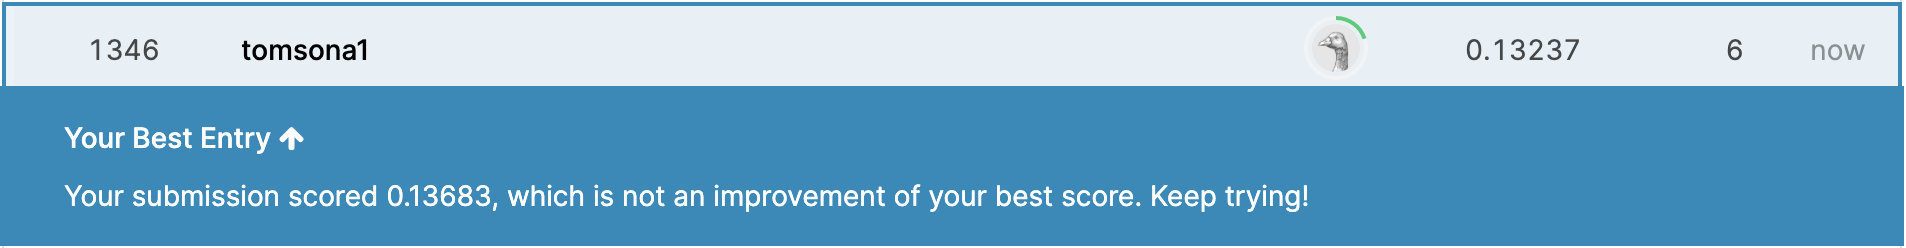
